In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.forecasting.theta               import ThetaForecaster
from sktime.forecasting.fbprophet           import Prophet
from sktime.forecasting.base                import ForecastingHorizon

from sklearn                import preprocessing 
from sklearn.metrics        import mean_squared_error,mean_absolute_percentage_error,mean_absolute_error
from sklearn.neighbors      import KNeighborsRegressor
from sklearn.linear_model   import Lasso

from sktime.forecasting.arima               import ARIMA
from sktime.forecasting.base                import ForecastingHorizon
from sktime.forecasting.trend               import PolynomialTrendForecaster,TrendForecaster
from sktime.forecasting.exp_smoothing       import ExponentialSmoothing
from sktime.forecasting.statsforecast       import StatsForecastAutoARIMA
from sktime.forecasting.compose             import TransformedTargetForecaster
from sktime.transformations.series.detrend  import Deseasonalizer,Detrender


from sktime.forecasting.compose import AutoEnsembleForecaster
from sktime.forecasting.compose import StackingForecaster


In [3]:
pdf = pd.read_csv("../data/monthly/ewz_stromabgabe_netzebenen_stadt_zuerich.csv",index_col=None)

pdf.index = pd.to_datetime(pdf['Timestamp'],utc=True)
pdf.index = pdf.index.tz_localize(None)  
pdf["y"] = pdf["NE7_GWh"].values
pdf = pdf.drop(columns=["Timestamp","NE5_GWh","NE7_GWh"])

split = len(pdf)-12
pdf_train, pdf_test = pdf.iloc[:split], pdf.iloc[split:]

In [4]:
idx = pd.period_range(start=pdf_train.index[0], end= pdf_train.index[-1], freq="M")
y = pd.Series(pdf_train.y.values, index=idx)

In [5]:
arima = TransformedTargetForecaster([
                                    ("detrend",         Detrender(forecaster=TrendForecaster(Lasso()))),
                                    ("deseasonalize",   Deseasonalizer(model="additive", sp=12)),
                                    ("forecast",        ARIMA())  
                                    ])

prophet =   Prophet(seasonality_mode='additive',yearly_seasonality=True)
exp     =   ExponentialSmoothing(trend='add', seasonal='additive', sp=12)  
theta   =   ThetaForecaster(sp=12)

forecasters= {"theta":theta,
              "prophet":prophet,
              "arima with lasso-detrend": arima,
              "exp": exp,
              }

                
one_year_predictions = {}
five_years_predictions = {}

for name,forecaster in forecasters.items():
    forecaster.fit(y)
    #one year ahead prediction   
    idx = pd.period_range(start=pdf_test.index[0], end= pdf_test.index[-1], freq="M")
    horizon = ForecastingHorizon(idx, is_relative=False)
    one_year  = forecaster.predict(fh=horizon)
    one_year_predictions[name] = one_year

    #five years ahead prediction
    idx = pd.period_range(start=pdf_test.index[0], periods=60, freq="M")
    horizon = ForecastingHorizon(idx, is_relative=False)
    five_years  = forecaster.predict(fh=horizon)
    five_years_predictions[name] = five_years


16:59:25 - cmdstanpy - INFO - Chain [1] start processing
16:59:26 - cmdstanpy - INFO - Chain [1] done processing


In [19]:
ensemble = StackingForecaster(forecasters=[("prophet",prophet),("exp",exp)])

#five years ahead prediction
idx = pd.period_range(start=pdf_test.index[0], periods=60, freq="M")
horizon = ForecastingHorizon(idx, is_relative=False)
ensemble.fit(y, fh= horizon)


17:04:22 - cmdstanpy - INFO - Chain [1] start processing
17:04:23 - cmdstanpy - INFO - Chain [1] done processing
17:04:24 - cmdstanpy - INFO - Chain [1] start processing
17:04:26 - cmdstanpy - INFO - Chain [1] done processing


StackingForecaster(forecasters=[('prophet', Prophet(yearly_seasonality=True)),
                                ('exp',
                                 ExponentialSmoothing(seasonal='additive',
                                                      sp=12, trend='add'))])

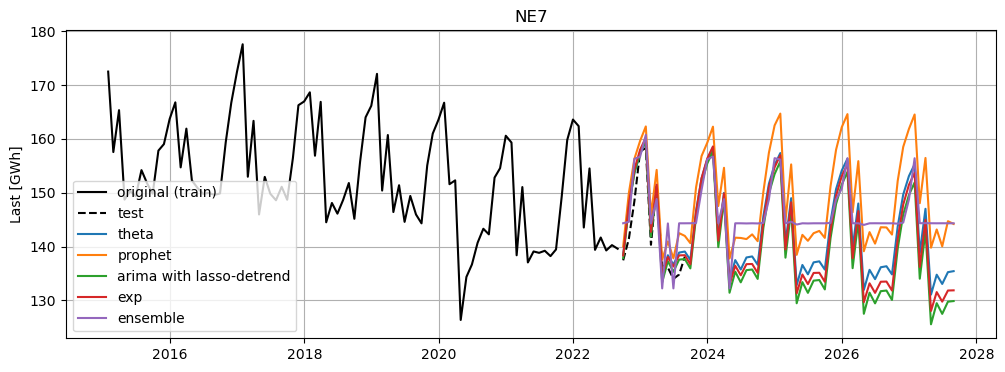

In [20]:
f, axes = plt.subplots(1, 1, figsize=(12, 4))

axes.plot(pdf_train.index, pdf_train.values, color="black", label="original (train)")
axes.plot(pdf_test, color="black",linestyle="--",label="test")

for key, value in five_years_predictions.items():
    axes.plot(value.index, value.values, label=key)

axes.plot(ensemble.predict(fh=horizon).index, ensemble.predict(fh=horizon).values, label="ensemble")
axes.legend()
axes.set_title("NE7")
axes.set_ylabel("Last [GWh]")
axes.grid()
plt.show()

In [17]:
    def loss_function(weights):
        # fc = np.average(pred_wide[candidates], weights=weights, axis=1)
        # This is faster
        fc = np.sum(pred_wide[candidates].values * np.array(weights), axis=1)
        return metric_fn(pred_wide[target].values, fc)

    opt_weights = optimize.minimize(
        loss_function,
        x0=[1 / len(candidates)] * len(candidates),
        constraints=({"type": "eq", "fun": lambda w: 1 - sum(w)}),
        method="SLSQP",  # 'SLSQP', Nelder-Mead
        bounds=[(0.0, 1.0)] * len(candidates),
        options={"ftol": 1e-10},
    )["x"]

NameError: name 'optimize' is not defined